In [2]:
import zipfile
import os

with zipfile.ZipFile("train.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/training_images")

In [3]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Directory and image size
DATADIR = "/content/training_images/train"
IMG_SIZE = 224  # Required size for MobileNetV2

features = []
labels = []

# Load pretrained MobileNetV2 (exclude classification layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

print("Extracting features from images...")
for img_name in tqdm(os.listdir(DATADIR)):
    try:
        label = 0 if "dog" in img_name.lower() else 1 if "cat" in img_name.lower() else None
        if label is None:
            continue

        img_path = os.path.join(DATADIR, img_name)
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Extract feature
        feature = base_model.predict(img_array, verbose=0)
        features.append(feature.flatten())
        labels.append(label)

    except Exception as e:
        pass  # You can print(e) if needed for debugging

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/tmp/ipython-input-4049131128.py:22: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting features from images...


100%|██████████| 25000/25000 [35:49<00:00, 11.63it/s]


Training SVM classifier...
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2539
           1       0.98      0.98      0.98      2461

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



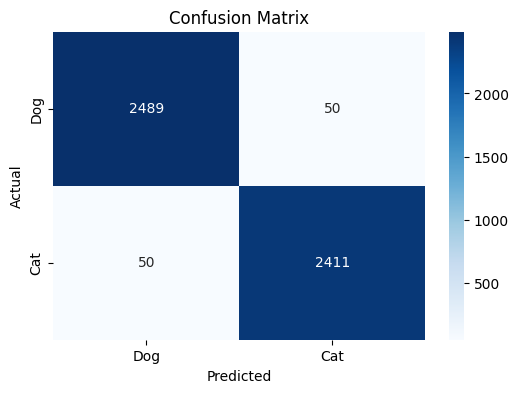

In [4]:
# Train SVM
print("Training SVM classifier...")
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Dog", "Cat"], yticklabels=["Dog", "Cat"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [5]:
import joblib
joblib.dump(clf, 'svm_mobilenet_model.pkl')  # Saves to your Colab session

['svm_mobilenet_model.pkl']

In [6]:
from google.colab import drive
drive.mount('/content/drive')

# Then move the model to your drive
!cp svm_mobilenet_model.pkl /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def predict_image(img_path, model, feature_extractor):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    feature = feature_extractor.predict(img_array)
    prediction = model.predict(feature)

    return "Dog" if prediction[0] == 0 else "Cat"

# Example
result = predict_image('/content/training_images/train/dog.99.jpg', clf, base_model)
result1 = predict_image('/content/training_images/train/cat.99.jpg', clf, base_model)
print("Prediction:", result)
print("Prediction:", result1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Prediction: Dog
Prediction: Cat
